In [16]:
import torch 
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from dataclasses import dataclass
from torch.utils.data import DataLoader, Subset

class PreProcessCathodeData:
 
    def __init__(self, 
                 data, 
                 methods: list=['standardize'],
                 summary_stats: dict=None
                 ):
        
        self.features = data
        self.methods = methods
        self.summary_stats = {} if summary_stats is None else summary_stats

    def preprocess(self):
        if self.methods is not None:
            for method in self.methods:
                method = getattr(self, method, None)
                if method and callable(method): method()
                else: raise ValueError('Preprocessing method {} not implemented'.format(method))
        else: pass

    def normalize(self, alpha=1e-5):
        """ normalize data 
        """
        if 'min' not in self.summary_stats.keys(): self.summary_stats['min'] = torch.min(self.features, dim=0)[0] + alpha
        if 'max' not in self.summary_stats.keys(): self.summary_stats['max'] = torch.max(self.features, dim=0)[0] - alpha
        self.features = (self.features - self.summary_stats['min'] ) / (self.summary_stats['max'] - self.summary_stats['min'])
    
    def standardize(self, sigma: float=1.0):
        """ standardize data
        """
        if 'mean' not in self.summary_stats.keys(): self.summary_stats['mean'] = torch.mean(self.features, dim=0)
        if 'std' not in self.summary_stats.keys(): self.summary_stats['std'] = torch.std(self.features, dim=0)
        self.features = (self.features - self.summary_stats['mean']) / (self.summary_stats['std'] / sigma)




class CathodeClassifierDataset(Dataset):

    def __init__(self,  model_data, reference_data, signal_noise_ratio=0.01, mass_window=[3300, 3700], methods=['standardize']):

        self.model_data = model_data
        self.ref_data = reference_data
        self.snr = signal_noise_ratio
        self.mass_window = mass_window
        self.preprocess_methods = methods
         
        self.get_reference_data()
        self.get_generated_data()

    def __getitem__(self, idx):
        output = {}
        output['data'] = self.data_preprocess[idx]
        output['labels'] = self.labels[idx]
        return output

    def __len__(self):
        return self.data.size(0)
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def get_generated_data(self):
        '''
        background_estimation : (1, mj1, delta_mj, tau21_1, tau21_2)
        labels : (class labels)
        data : (mj1, delta_mj, tau21_1, tau21_2)
        data_preprocess : (mj1, delta_mj, tau21_1, tau21_2)
        '''
        f = h5py.File(self.model_data, 'r') 
        data = torch.Tensor(f['jet high level features'])
        self.background_estimation  = torch.concat([torch.ones(data.size(0), 1), data[..., 1:]], dim=-1)
        data = torch.concat([self.background_estimation, self.data_ref], dim=0)
        data = data[torch.randperm(data.size(0))]
        self.labels = data[..., 0]
        self.data = data[..., 1:]
        _data = PreProcessCathodeData(data=self.data, methods=self.preprocess_methods)
        _data.preprocess()
        self.data_preprocess = _data.features.clone()
        f.close()

    def get_reference_data(self):
        '''
        background_truth : (0, mjj,  mj1, delta_mj, tau21_1, tau21_2)
        signal_truth : (1, mjj,  mj1, delta_mj, tau21_1, tau21_2)
        data_ref : (0, mj1, delta_mj, tau21_1, tau21_2)
        '''
        f = h5py.File(self.ref_data, 'r') 
        data = torch.Tensor(f['jet features'])
        mask_mass_window = (data[...,1] > self.mass_window[0] ) & (data[...,1] < self.mass_window[1])
        data = data[mask_mass_window]
        mask_signal = data[...,0] == 1
        self.signal_truth = data[mask_signal]
        self.background_truth = data[~mask_signal]
        S=self.signal_truth.size(0)
        B=self.background_truth.size(0)
        idx = torch.randperm(S)[: int(self.snr * B)]
        self.signal_truth = self.signal_truth[idx]
        print('INFO: truth data S={}, B={}, SNR={}'.format(self.signal_truth.shape[0], B, np.round(self.signal_truth.shape[0]/B, 4)))
        data = torch.cat([self.signal_truth, self.background_truth], dim=0)
        data = data[torch.randperm(data.size(0))]
        self.data_ref = torch.concat([torch.zeros(data.size(0), 1), data[..., 2:]], dim=-1)
        f.close()


class CathodeDataLoader:

    def __init__(self, 
                 datasets: Dataset, 
                 data_split_fracs= [0.8, 0.2, 0.0], 
                 batch_size=256,
                 ):

        self.datasets = datasets        
        self.fracs = data_split_fracs
        self.batch_size = batch_size
        self.dataloader()

    def train_val_test_split(self, shuffle=False):
        assert np.abs(1.0 - sum(self.fracs)) < 1e-3, "Split fractions do not sum to 1!"
        total_size = len(self.datasets)
        train_size = int(total_size * self.fracs[0])
        valid_size = int(total_size * self.fracs[1])

        #...define splitting indices

        idx = torch.randperm(total_size) if shuffle else torch.arange(total_size)
        idx_train = idx[:train_size].tolist()
        idx_valid = idx[train_size : train_size + valid_size].tolist()
        idx_test = idx[train_size + valid_size :].tolist()
        
        #...Create Subset for each split

        train_set = Subset(self.datasets, idx_train)
        valid_set = Subset(self.datasets, idx_valid) if valid_size > 0 else None
        test_set = Subset(self.datasets, idx_test) if self.fracs[2] > 0 else None

        return train_set, valid_set, test_set


    def dataloader(self):

        print("INFO: building dataloaders...")
        print("INFO: train/val/test split ratios: {}/{}/{}".format(self.fracs[0], self.fracs[1], self.fracs[2]))
        
        train, valid, test = self.train_val_test_split(shuffle=True)
        self.train = DataLoader(dataset=train, batch_size=self.batch_size, shuffle=True)
        self.valid = DataLoader(dataset=valid,  batch_size=self.batch_size, shuffle=False) if valid is not None else None
        self.test = DataLoader(dataset=test,  batch_size=self.batch_size, shuffle=True) if test is not None else None

        print('INFO: train size: {}, validation size: {}, testing sizes: {}'.format(len(self.train.dataset),  # type: ignore
                                                                                    len(self.valid.dataset if valid is not None else []),  # type: ignore
                                                                                    len(self.test.dataset if test is not None else []))) # type: ignore




### data

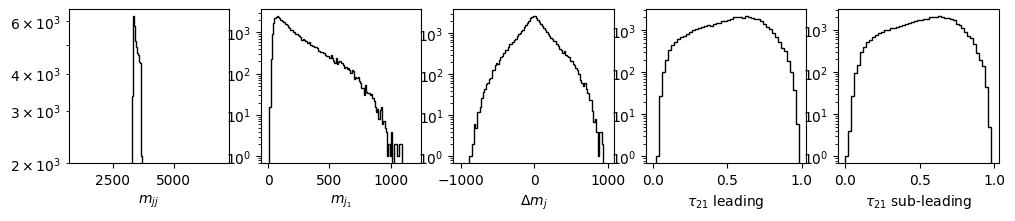

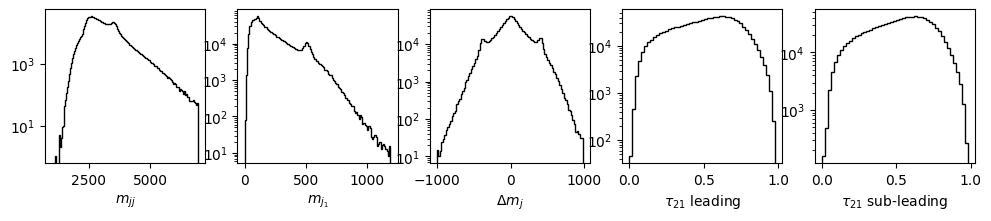

In [17]:
import torch 
import matplotlib.pyplot as plt
import h5py
import numpy as np


model_data = '../results/LHCOlympics.SchrodingerBridgeFlowMatching.MLP_forward.2023.11.30_20h51/events_generated_interpolation.h5'
reference_data = '../data/LHCOlympics2020/events_anomalydetection_high_level_cathode_with_signal.h5'

f = h5py.File(model_data, 'r') 
gen_data = torch.Tensor(f['jet high level features'])

f = h5py.File(reference_data, 'r') 
ref_data = torch.Tensor(f['jet features'])

#...plots

features = [r'$m_{jj}$', r'$m_{j_1}$', r'$\Delta m_{j}$', r'$\tau_{21}$ leading', r'$\tau_{21}$ sub-leading']

bins = [np.arange(1000, 7000, 40),
        np.arange(0, 1200, 10), 
        np.arange(-1000, 1000, 20), 
        np.arange(0, 1, 0.02), 
        np.arange(0, 1, 0.02)]

fig, ax = plt.subplots(1, 5, figsize=(12,2))
for i in range(5):
    ax[i].hist(gen_data[...,i], bins=bins[i], histtype='step', color='k', density=False, log=True)
    ax[i].set_xlabel(features[i])

fig, ax = plt.subplots(1, 5, figsize=(12,2))
features = [r'$m_{jj}$', r'$m_{j_1}$', r'$\Delta m_{j}$', r'$\tau_{21}$ leading', r'$\tau_{21}$ sub-leading']
for i in range(5):
    ax[i].hist(ref_data[...,i+1], bins=bins[i], histtype='step', color='k', density=False, log=True)
    ax[i].set_xlabel(features[i])

### define datasets & dataloader for Signal Region (SR)

In [19]:
dataset = CathodeClassifierDataset(model_data=model_data,
                                   reference_data=reference_data,
                                   signal_noise_ratio=0.05,
                                   mass_window=[3300, 3700])

dataloader = CathodeDataLoader(datasets=dataset, data_split_fracs=[0.5, 0.1, 0.4], batch_size=256)

INFO: truth data S=6067, B=121352, SNR=0.05
INFO: building dataloaders...
INFO: train/val/test split ratios: 0.5/0.1/0.4
INFO: train size: 89275, validation size: 17855, testing sizes: 71421


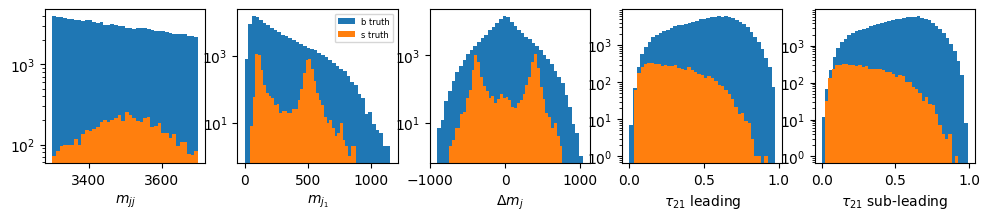

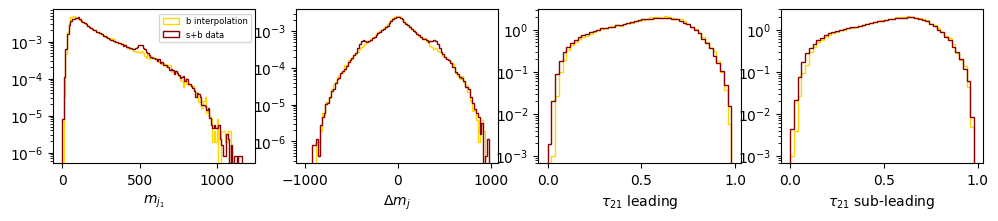

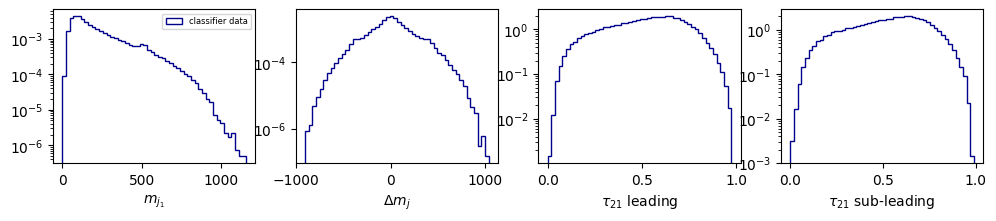

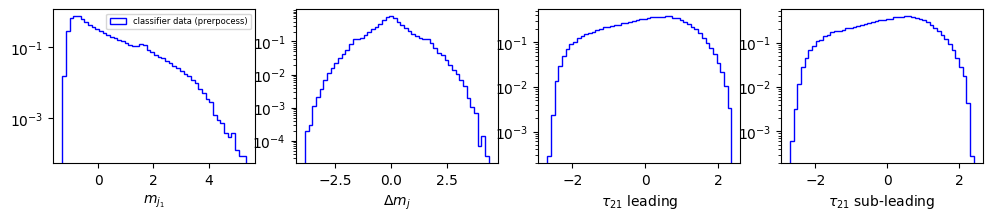

In [20]:
fig, ax = plt.subplots(1, 5, figsize=(12,2))
for i in range(5):
    ax[i].hist(dataset.background_truth[...,1+i], bins=40, histtype='stepfilled', density=False, log=True, label='b truth')
    ax[i].hist(dataset.signal_truth[...,1+i], bins=40, histtype='stepfilled', density=False, log=True, label='s truth')
    ax[i].set_xlabel(features[i])
    if i==1: ax[i].legend(loc='upper right', fontsize=6)

fig, ax = plt.subplots(1, 4, figsize=(12,2))
for i in range(4):
    ax[i].hist(dataset.background_estimation[...,1+i], bins=bins[i+1],  color='gold', density=True, log=True, histtype='step', label='b interpolation')
    ax[i].hist(dataset.data_ref[...,1+i], bins=bins[1+i], density=True, color='darkred', log=True, histtype='step', label='s+b data')
    ax[i].set_xlabel(features[1+i])
    if i==0: ax[i].legend(loc='upper right', fontsize=6)

fig, ax = plt.subplots(1, 4, figsize=(12,2))
for i in range(4):
    ax[i].hist(dataset.data[...,i], bins=50, density=True, color='darkblue', log=True, histtype='step', label='classifier data')
    ax[i].set_xlabel(features[1+i])
    if i==0: ax[i].legend(loc='upper right', fontsize=6)

fig, ax = plt.subplots(1, 4, figsize=(12,2))
for i in range(4):
    ax[i].hist(dataset.data_preprocess[...,i], bins=50, density=True, color='blue', log=True, histtype='step', label='classifier data (prerpocess)')
    ax[i].set_xlabel(features[1+i])
    if i==0: ax[i].legend(loc='upper right', fontsize=6)


# Classifier Test

In [21]:
from DynGenModels.configs.classifier_configs import Cathode_MLP_Classifier as Configs

workdir = '../results/LHCOlympics.SchrodingerBridgeFlowMatching.MLP_forward.2023.11.30_20h51'

configs = Configs(# data:
                DATA = 'Cathode',
                data_gen_model = workdir + '/events_generated_interpolation.h5',
                data_reference = '../data/LHCOlympics2020/events_anomalydetection_high_level_cathode_with_signal.h5',
                signal_noise_ratio = 0.05,
                mass_window = [3300, 3700], 
                preprocess = ['standardize'],
                dim_input = 4,
                # training params:   
                DEVICE = 'cuda:1',
                EPOCHS = 1000,
                batch_size = 128,
                print_epochs = 5,
                min_epochs = 200,
                early_stopping = 25,
                data_split_fracs = [0.8, 0.2, 0.0],
                lr = 1e-3,
                optimizer = 'Adam',
                fix_seed = 12345,
                # model params:
                DYNAMICS = 'BinaryClassifierTest', 
                MODEL = 'MLP',
                dim_hidden = 64,
                num_layers = 3,
                activation = 'Sigmoid',
                )

configs.set_workdir(path=workdir, dir_name='classifier', save_config=True)


#=====================================================================================================================
INFO: created directory: ../results/LHCOlympics.SchrodingerBridgeFlowMatching.MLP_forward.2023.11.30_20h51/classifier
#=====================================================================================================================
+---------------------+---------------------------------------------------------------------------------------------------------------------+
| Parameters          | Values                                                                                                              |
+---------------------+---------------------------------------------------------------------------------------------------------------------+
| DATA                | Cathode                                                                                                             |
| data_gen_model      | ../results/LHCOlympics.SchrodingerBridgeFlowMatching

In [22]:
from DynGenModels.datamodules.cathode.datasets import CathodeClassifierDataset
from DynGenModels.datamodules.cathode.dataloader import CathodeDataLoader 
from DynGenModels.models.deep_nets import ClassifierNet
from DynGenModels.metrics.classifier import BinaryClassifierTest
from DynGenModels.trainer.trainer import ClassifierTrainer


cathode = CathodeClassifierDataset(configs)
classifier  = ClassifierTrainer(classifier = BinaryClassifierTest(configs),
                                model = ClassifierNet(configs), 
                                dataloader = CathodeDataLoader(cathode, configs), 
                                configs = configs)

classifier.train()
classifier.test(cathode.data_ref_test)

INFO: truth data S=3033, B=60676, SNR=0.05
INFO: building dataloaders...
INFO: train/val/test split ratios: 0.8/0.2/0.0
INFO: train size: 81811, validation size: 20452, testing sizes: 0


number of training parameters: 4545
start classifier training...


epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

	Epoch: 1, train loss: 0.6929276672191921, valid loss: 0.6941605098545551  (min valid loss: 0.6931734889745711)
	Epoch: 6, train loss: 0.6929359866306187, valid loss: 0.6942343059927225  (min valid loss: 0.6924950167536736)
	Epoch: 11, train loss: 0.6923559770919387, valid loss: 0.6924964215606448  (min valid loss: 0.6923276286572217)
	Epoch: 16, train loss: 0.6920250804163516, valid loss: 0.6922342058271166  (min valid loss: 0.692030800879002)
	Epoch: 21, train loss: 0.6917679138481609, valid loss: 0.6918151009827849  (min valid loss: 0.6918151009827849)
	Epoch: 26, train loss: 0.691524830646813, valid loss: 0.6915184885263442  (min valid loss: 0.6915184885263442)
	Epoch: 31, train loss: 0.6909855363890534, valid loss: 0.6911115206778049  (min valid loss: 0.6911115206778049)
	Epoch: 36, train loss: 0.6906170428730546, valid loss: 0.690999270230532  (min valid loss: 0.690999270230532)
	Epoch: 41, train loss: 0.6903206385672087, valid loss: 0.6911725711077451  (min valid loss: 0.6908781

/tmp/ipykernel_1462762/1015315563.py:25: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(tpr, 1/fpr, color='gold', label='ROC curve (area = %0.2f)' % roc_auc)


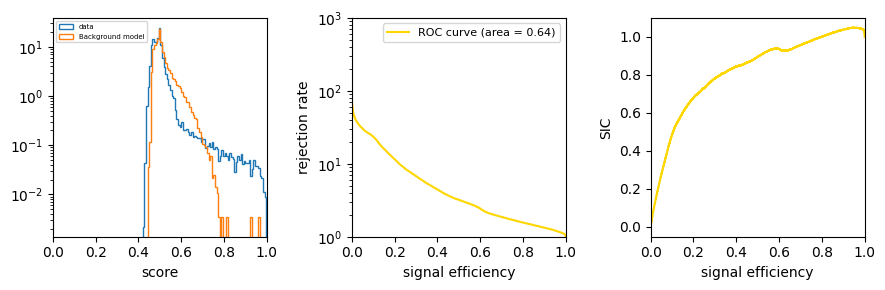

In [10]:

import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.metrics import roc_curve, auc


score_class_0 = classifier.predictions[0].squeeze()
score_class_1 = classifier.predictions[1].squeeze()
class_labels = classifier.predictions['datasets'][..., 1]
scores = classifier.predictions['datasets'][..., 0]
fpr, tpr, _ = roc_curve(class_labels, scores, pos_label=1)
sic = np.ma.divide(tpr, np.sqrt(fpr)).filled(0)
roc_auc = auc(fpr, tpr)

# plot scrores:

fig, ax = plt.subplots(1, 3, figsize=(9,3))
ax[0].hist(score_class_0, bins=np.arange(0,1,0.0075), density=True, histtype='step', label='data', log=True)
ax[0].hist(score_class_1, bins=np.arange(0,1,0.0075), density=True, histtype='step', label='Background model', log=True)
ax[0].set_xlabel(r'score')
ax[0].legend(fontsize=5, loc='upper left')
ax[0].set_xlim(0, 1)

ax[1].plot(tpr, 1/fpr, color='gold', label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([1., 1000.0])
ax[1].set_xlabel('signal efficiency')
ax[1].set_ylabel('rejection rate')
ax[1].set_yscale('log')
ax[1].legend(fontsize=8, loc='upper right')

ax[2].plot(tpr, sic, color='gold')
ax[2].set_xlim([0.0, 1.0])
ax[2].set_xlabel('signal efficiency')
ax[2].set_ylabel('SIC')
plt.tight_layout()
plt.show()

